<a href="https://colab.research.google.com/github/Kuber757/google_landmark_recoganization/blob/main/landmark_with_data_augmentation1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
image_size = (180, 180)
batch_size = 32
# /content/drive/My Drive/data_trial_core
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/My Drive/data_trial_core",
    validation_split=0.01,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/My Drive/data_trial_core",
    validation_split=0.3,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 1074 files belonging to 7 classes.
Using 1064 files for training.
Found 1074 files belonging to 7 classes.
Using 322 files for validation.


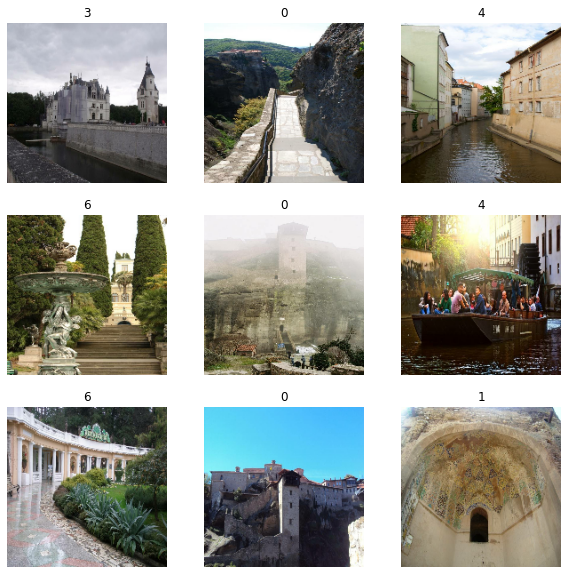

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
        layers.experimental.preprocessing.RandomContrast(0.3),
    ]
)

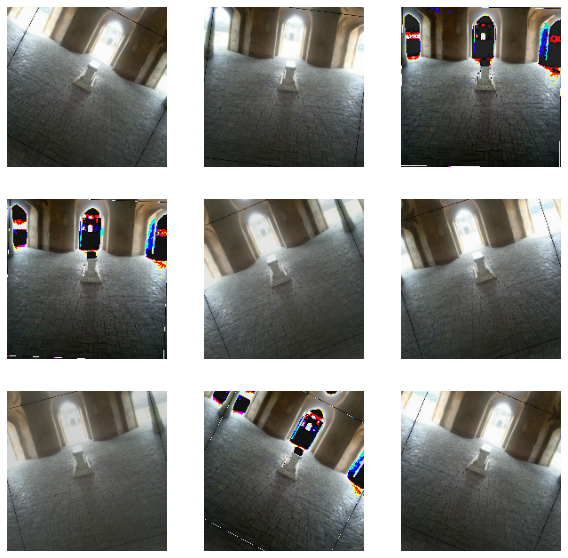

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [ ]:
inputs = keras.Input(shape=(180,180,3))
x = data_augmentation(inputs)
x = layers.experimental.preprocessing.Rescaling(1./255)(x)

In [ ]:
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))

In [ ]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

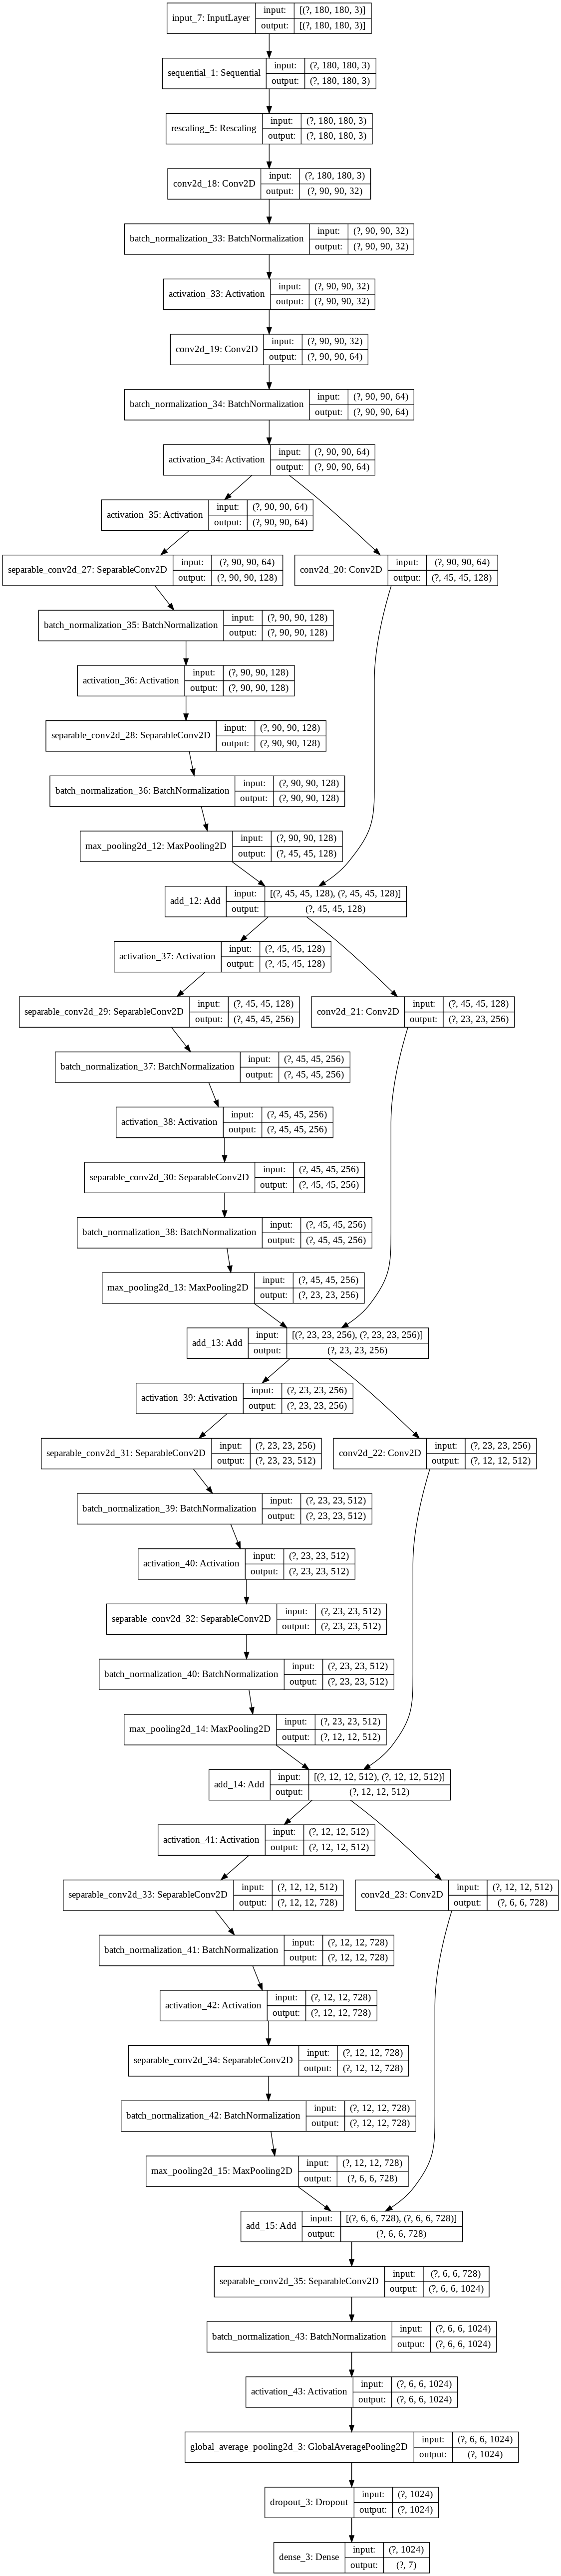

In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    


    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=7)
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
epochs = 20

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/20
34/34 [==============================] - 284s 8s/step - loss: 6.4384 - accuracy: 0.1400 - val_loss: 5.8585 - val_accuracy: 0.1149
Epoch 2/20
34/34 [==============================] - 282s 8s/step - loss: 6.2234 - accuracy: 0.1372 - val_loss: 5.8579 - val_accuracy: 0.0901
Epoch 3/20
34/34 [==============================] - 283s 8s/step - loss: 6.1172 - accuracy: 0.1438 - val_loss: 5.8579 - val_accuracy: 0.1149
Epoch 4/20
34/34 [==============================] - 286s 8s/step - loss: 6.0284 - accuracy: 0.1259 - val_loss: 5.8579 - val_accuracy: 0.1149
Epoch 5/20
34/34 [==============================] - 288s 8s/step - loss: 5.9625 - accuracy: 0.1447 - val_loss: 5.8578 - val_accuracy: 0.1149
Epoch 6/20
34/34 [==============================] - 279s 8s/step - loss: 5.9200 - accuracy: 0.1353 - val_loss: 5.8577 - val_accuracy: 0.0901
Epoch 7/20
34/34 [==============================] - 284s 8s/step - loss: 5.8987 - accuracy: 0.1635 - val_loss: 5.8577 - val_accuracy: 0.1149
Epoch 8/20
34